# Desarrollo de modelos

Este notebook se utiliza para el desarrollo de modelos de clasificación para el problema seleccionado. 
El procedimiento está organizado en las siguientes secciones:

1. Carga del dataset
2. Análisis Exploratorio de Datos
3. Preprocesamiento
4. Ingeniería de Features
5. Desarrollo y Entrenamiento de Modelos

## Descripción del problema

Dado un [dataset de operaciones con tarjetas de crédito (fuente:Kaggle)](https://www.kaggle.com/mlg-ulb/creditcardfraud) que tiene etiquetadas operaciones identificadas como fraude o no fraude, interesa elaborar un modelo que permita clasificar automáticamente nuevas operaciones.

El dataset contiene:
- **Información temporal**: Los segundos transcurridos desde la primer operación registrada en el dataset. El tiempo inicial real es desconocido. Dado que este campo no se utiliza, se asignó una fecha arbitraria sólo con la finalidad de visualizar los datos en herramientas que soportan la búsqueda por indexado temporal (ejemplos: Grafana y Kibana).
- **Features v1-v28**: de acuerdo a la descripción del dataset, características resultantes de haber aplicado PCA para proteger la identidad de los usuarios y capturar aquellas de mayor relevancia para el problema.
- **Monto de la operación**
- **Resultado de la clasificación**: 0=No fraude, 1=Fraude.


### Alcance y Limitaciones

- Si bien está disponible la información temporal, los modelos estudiados en este trabajo tratarán el problema como si se tratara de eventos aislados. Están fuera del alcance RNNs, u otros algoritmos que utilicen información temporal.
- Se asume que las nuevas operaciones han pasado por el mismo proceso de PCA que el dataset original. Como este proceso es desconocido en este ejericicio, se particionará el dataset en un lote de datos para desarrollo del modelo (entrenamiento o entrenamiento/validación dependiendo del caso) y otro lote para evaluación.

## Procedimiento

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import joblib

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

TMP_PATH = "./tmp/" # Path temporal usado para imágenes generadas, archivos intermedios, etc.
MODELS_PATH = "/models/"

### 1. Carga del dataset

Se puede cargar el dataset desde el archivo CSV original o desde ElasticSearch. Para este trabajo se propone el segundo método.

#### Opción 1) De archivo CSV.

In [2]:
DATASET_FILENAME_PATH = "/data/credit_fraud/creditcard.csv"

def load_credit_fraud_from_csv(path=DATASET_FILENAME_PATH):
    col_names = [ "time" ]
    col_names.extend(["v{}".format(x) for x in range(1,28)])
    col_names.append( "amount" )
    col_names.append( "class" )
    return pd.read_csv(DATASET_FILENAME_PATH,skiprows=1,index_col=0, names=col_names)

#### Opción 2) De ElasticSearch.

In [3]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search

ELASTICSEARCH_HOST = 'elasticsearch'
ELASTICSEARCH_PORT = 9200
ELASTICSEARCH_DATASET_INDEX = 'creditfraud-1'

def load_credit_fraud_from_elasticsearch(host=ELASTICSEARCH_HOST,port=ELASTICSEARCH_PORT, 
                                         index=ELASTICSEARCH_DATASET_INDEX):
    es = Elasticsearch(f"http://{ELASTICSEARCH_HOST}:{ELASTICSEARCH_PORT}/")
    s = Search(using=es, index=index)
    return pd.DataFrame([hit.to_dict() for hit in s.scan()]).astype(float)

In [4]:
#df = load_credit_fraud_from_csv()
df = load_credit_fraud_from_elasticsearch()

### 2. Análisis Exploratorio de Datos

A continuación se hará una exploración inicial del dataset.

In [5]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,class,row_id
0,1.602720e+09,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0,0.0
1,1.602720e+09,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0,1.0
2,1.602720e+09,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0,2.0
3,1.602720e+09,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0,3.0
4,1.602720e+09,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0,4.0


Vista de tipos de datos de columnas (nota: los campos de interés ya han sido convertidos a Float previamente).

In [6]:
df.dtypes

time      float64
v1        float64
v2        float64
v3        float64
v4        float64
v5        float64
v6        float64
v7        float64
v8        float64
v9        float64
v10       float64
v11       float64
v12       float64
v13       float64
v14       float64
v15       float64
v16       float64
v17       float64
v18       float64
v19       float64
v20       float64
v21       float64
v22       float64
v23       float64
v24       float64
v25       float64
v26       float64
v27       float64
v28       float64
amount    float64
class     float64
row_id    float64
dtype: object

Estadísticas generales.

In [7]:
df.describe()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,class,row_id
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000
mean,1.602815e+09,2.923228e-15,2.941874e-16,-7.913248e-15,1.894555e-15,9.829743e-16,1.470984e-15,-1.045995e-15,-2.445951e-16,-1.869256e-15,...,-4.302640e-16,6.094655e-17,4.444939e-15,1.606285e-15,1.737425e-15,-3.925610e-16,-1.152161e-16,88.349619,0.001727,142403.000000
std,4.748815e+04,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,82216.843396
min,1.602720e+09,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,0.000000
25%,1.602774e+09,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,71201.500000
50%,1.602805e+09,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,142403.000000
75%,1.602859e+09,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,213604.500000
max,1.602893e+09,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,284806.000000


Distribución de clases. 

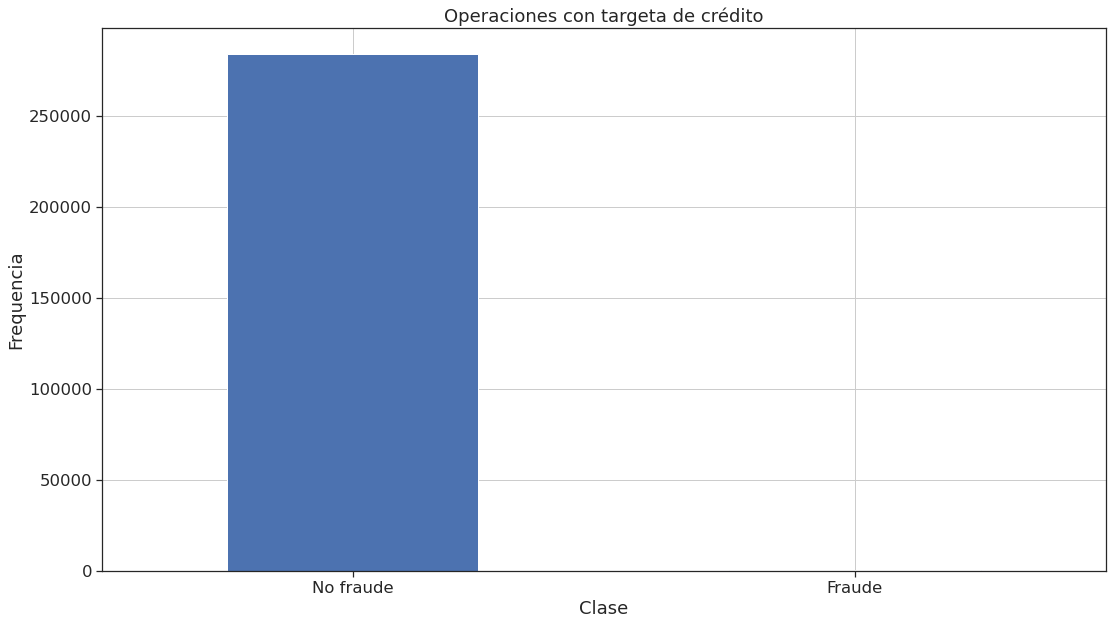

In [8]:
count_classes = pd.value_counts(df['class'], sort = True)
plt.figure(figsize=(18,10))
count_classes.plot(kind = 'bar', rot=0)
plt.title("Operaciones con targeta de crédito")
plt.xticks(range(2), ["No fraude", "Fraude"])
plt.grid(which="Both")
plt.xlabel("Clase")
plt.ylabel("Frequencia")
plt.show()

Lo primero que se observa es que el dataset está fuertemente desbalanceado. Esto representa un problema que se tratará en la etapa siguiente de preprocesamiento.

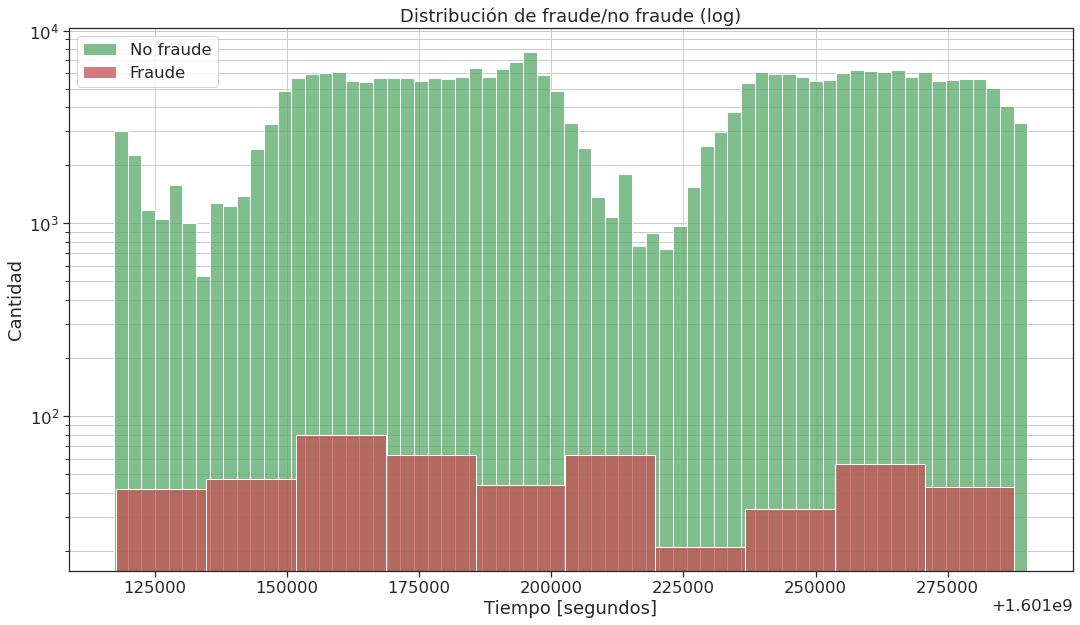

In [9]:
def plot_class_distribution_in_time(df, title,log=False):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(18,10))
    ax.set_title(title)
    sns.histplot(df[df['class']==0]['time']-df.time.min()/1000, color='g', label='No fraude',ax=ax) 
    sns.histplot(df[df['class']==1]['time']-df.time.min()/1000, color='r', label='Fraude',ax=ax) 
    ax.grid(which="Both")
    if log:
        ax.set_yscale('log')
    ax.legend(["No fraude","Fraude"])
    plt.xlabel("Tiempo [segundos]")
    plt.ylabel("Cantidad")
    
plot_class_distribution_in_time(df,title='Distribución de fraude/no fraude (log)',log=True)

### 2. Preprocesamiento de dataset

#### 2.1 Manejo de datos inválidos

Este dataset, al igual que muchos descargados de Kaggle, ya fue previamente procesado y no contiene filas con NaNs.

In [10]:
ds_with_nans = df.loc[df.isna().sum(axis=1)>=1,:]
ds_without_nans = df.loc[df.isna().sum(axis=1)==0,:]
print("Filas con NaNs:{}".format(ds_with_nans.shape[0]))
print("Filas sin NaNs: {}".format(ds_without_nans.shape[0]))

Filas con NaNs:0
Filas sin NaNs: 284807


#### 2.2 Manejo de datos imbalanceados.

Como se observó en el análisis exploratorio inicial, los datos están fuertemente desbalanceados en favor de los casos no fraudulentos.
Aquí se pueden adoptar distintas estrategias:
1. **Upsampling**: aumentar la cantidad de muestras de la clase minoritaria (agregando muestras reales o artificiales).
2. **Downsampling**: reducir la cantidad de muestras de la clase mayoritaria.
3. **Cambiar la métrica de evaluación**: no hacer nada en la preparación del dataset, y elegir una métrica de performance adecuada para este escenario.

Se procederá con la opción 2.

In [11]:
from sklearn.utils import resample

In [12]:
df_majority = df[df['class']==0]
df_minority = df[df['class']==1]

In [13]:
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=123)

In [14]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled['class'].value_counts()

1.0    492
0.0    492
Name: class, dtype: int64

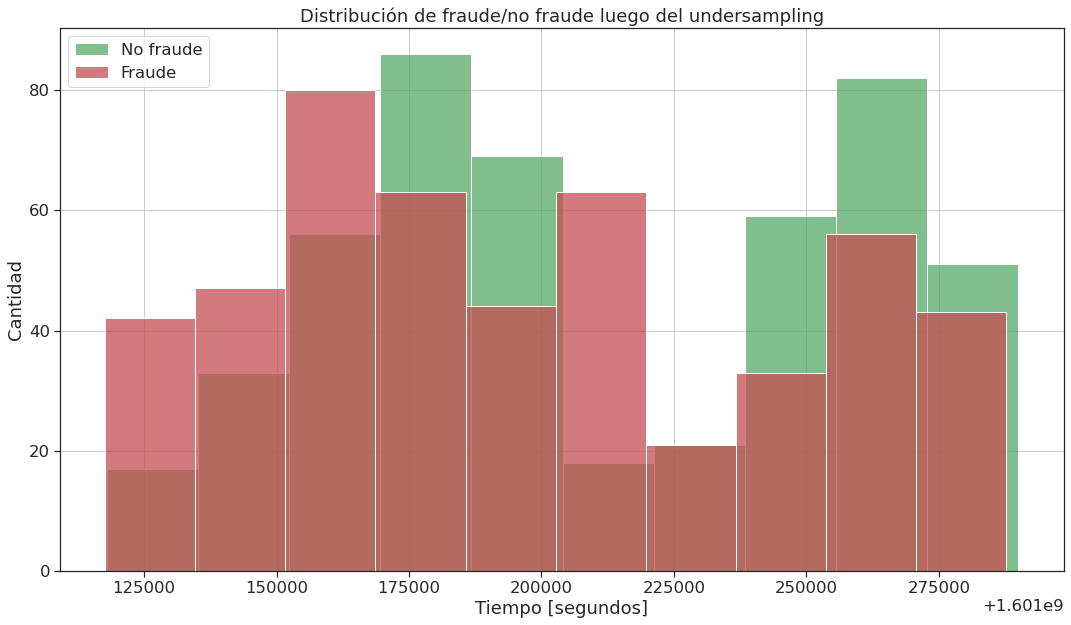

In [15]:
plot_class_distribution_in_time(df_downsampled,title='Distribución de fraude/no fraude luego del undersampling',
                                log=False)

In [16]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [17]:
non_feature_cols = ['time','row_id','class']
feature_cols = [x for x in df.columns if x not in non_feature_cols]
feature_cols

['v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9',
 'v10',
 'v11',
 'v12',
 'v13',
 'v14',
 'v15',
 'v16',
 'v17',
 'v18',
 'v19',
 'v20',
 'v21',
 'v22',
 'v23',
 'v24',
 'v25',
 'v26',
 'v27',
 'v28',
 'amount']

In [18]:
X = df_downsampled[feature_cols]
y = df_downsampled['class']

In [19]:
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=1)

### 3. Ingeniería de features

#### 3.1 Análisis por correlación

En este análisis se intentará saber cuales son las características que influyen fuertemenete en una operación identificada como fraudulenta. Es importante tener presente que en este análisis aún cuando una característica puede parecer no ser relevante, combinada con otra (u otras) sí podría serlo, y este aspecto pasaría desapercibido en este tipo de análisis.

In [20]:
exclude_corr_cols = ['time','row_id']
corr_cols = [x for x in df_downsampled.columns if x not in exclude_corr_cols]
df_downsampled_train = pd.concat([X_train, y_train], axis=1)

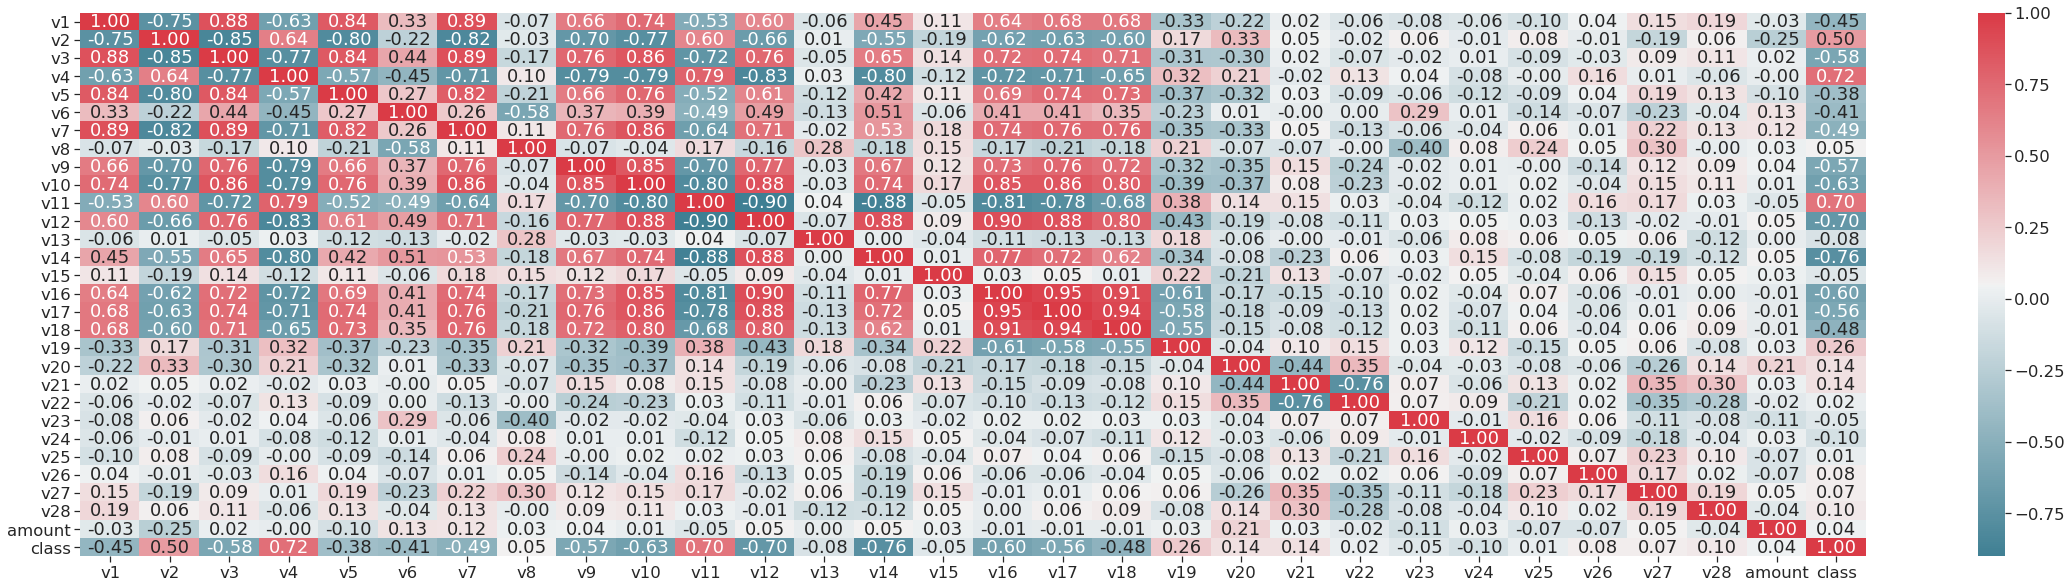

In [21]:
fig, ax1 = plt.subplots(1, figsize=(40,10))
corr = df_downsampled_train.corr() # Todo combinar con Y_train
sns.heatmap(corr, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

##### Conclusiones

- **Correlación negativa**: v1, v3,v5,v6,v7,v9,v10,v12,v14,v16,v17,v18 tienen valores de correlación negativos. Valores negativos más extremos están correlacionados con mayor probabilidad de fraude.
- **Correlación positiva**: v2,v4,v11,v19 estan positivamente correlacionados. Los valores más altos indican mayor probabilidad de fraude.

Es de interés analizar como están distribuidos los valores de estas características para cada resultado de la clasificación.

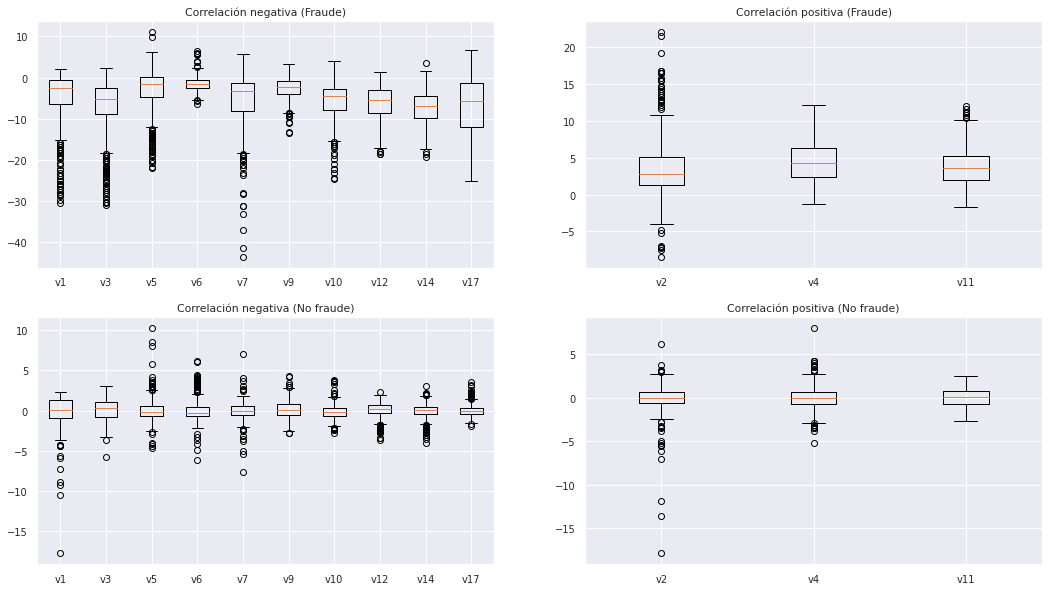

In [22]:
negative_corr = ['v1','v3','v5','v6','v7','v9','v10','v12','v14','v17']
positive_corr = ['v2','v4','v11']

pos_corr_plots_fraud = []
neg_corr_plots_fraud = []
pos_corr_plots_no_fraud = []
neg_corr_plots_no_fraud = []

for x in negative_corr:
    neg_corr_plots_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==1,x])
    neg_corr_plots_no_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==0,x])
    
for x in positive_corr:
    pos_corr_plots_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==1,x])
    pos_corr_plots_no_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==0,x])    

fig, axes = plt.subplots(2,2, figsize=(18,10))

axes[0][0].set_title("Correlación negativa (Fraude)")
axes[0][0].boxplot( neg_corr_plots_fraud )
axes[0][0].set_xticklabels(negative_corr)

axes[0][1].set_title("Correlación positiva (Fraude)")
axes[0][1].boxplot( pos_corr_plots_fraud )
axes[0][1].set_xticklabels(positive_corr)

axes[1][0].set_title("Correlación negativa (No fraude)")
axes[1][0].boxplot( neg_corr_plots_no_fraud)
axes[1][0].set_xticklabels(negative_corr)

axes[1][1].set_title("Correlación positiva (No fraude)")
axes[1][1].boxplot(pos_corr_plots_no_fraud)
axes[1][1].set_xticklabels(positive_corr)

plt.show()

#### 3.2 Análisis por Random Forest

Otro método para obtner aquellas características que influyan más en el resultado es aprovechando el algoritmo Random Forest.

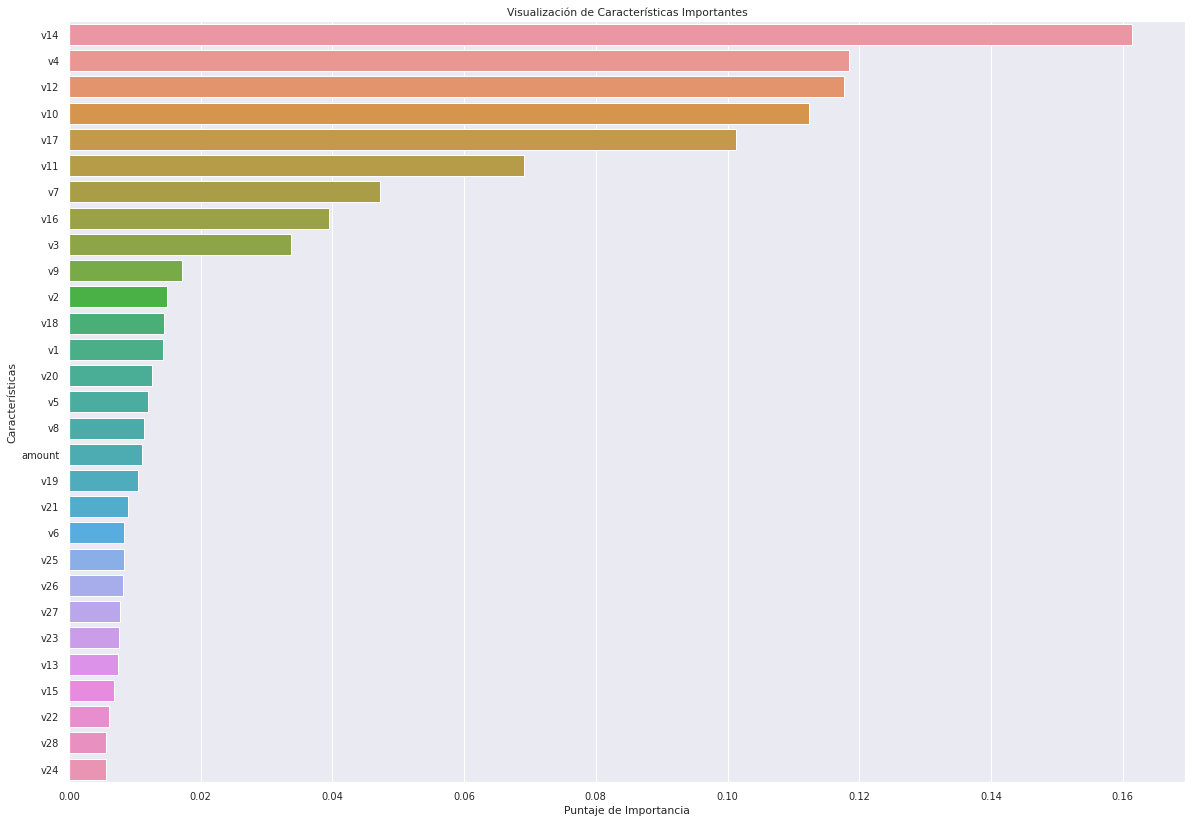

In [23]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train,y_train)

feature_imp = pd.Series(clf.feature_importances_,index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(20,14))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Puntaje de Importancia')
plt.ylabel('Características')
plt.title("Visualización de Características Importantes")
plt.show()

### 4. Entrenamiento de modelos

En esta sección se procederá a entrenar distintos tipos de modelos:
- Árbol de decisión
- Random Forest
- Regresión Logística
- Support Vector Machine

##### Criterio de evaluación. 

Para todos los modelos se obtendrán métricas relevantes para la clasificación binaria:
- Accuracy.
- Precision.
- Recall
- Matriz de Confusión
- Curva ROC

In [24]:
from sklearn.metrics import plot_confusion_matrix

def model_evaluation_report(model,y_test,y_pred,y_pred_prob):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
        
    #fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 3]))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1])
    auc = metrics.auc(fpr, tpr)
    f1_score = metrics.f1_score(y_test, y_pred)
    
    fig, axes = plt.subplots(1,2,figsize=(20,10))
    plot_confusion_matrix(model, X_test, y_test,ax=axes[0])  # doctest: +SKIP
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Etiqueta real')
    #plt.show()
    
    #plt.figure()
    axes[1].plot(fpr, tpr)
    axes[1].set_title("Curva ROC")
    axes[1].set_xlabel('Tasa de falsos positivos (1 - Especificidad)')
    axes[1].set_ylabel('Tasa de positivos (Sensibilidad)')
    plt.show()   
            
    print("AUC:", auc )
    print("Accuracy:", accuracy )
    print("Precision:", precision )
    print("Recall:", recall)
    print("f1-score: ", f1_score)
    
    model_summary={
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "auc": auc,
        "f1-score": f1_score
    }
    return model_summary

#model_evaluation_report(model,y_test,y_pred,y_pred_prob)

Los modelos serán exportados para poder servirse con una API REST.

In [25]:
def save_model(model, model_filename):    
    joblib.dump(model, MODELS_PATH+model_filename)

In [26]:
# Para futura tabla comparativa
model_metrics_list = {}

#### 4.1 Árboles de decisión

In [27]:
from sklearn.tree import DecisionTreeClassifier
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

##### 4.1 Modelo 1, sin poda 

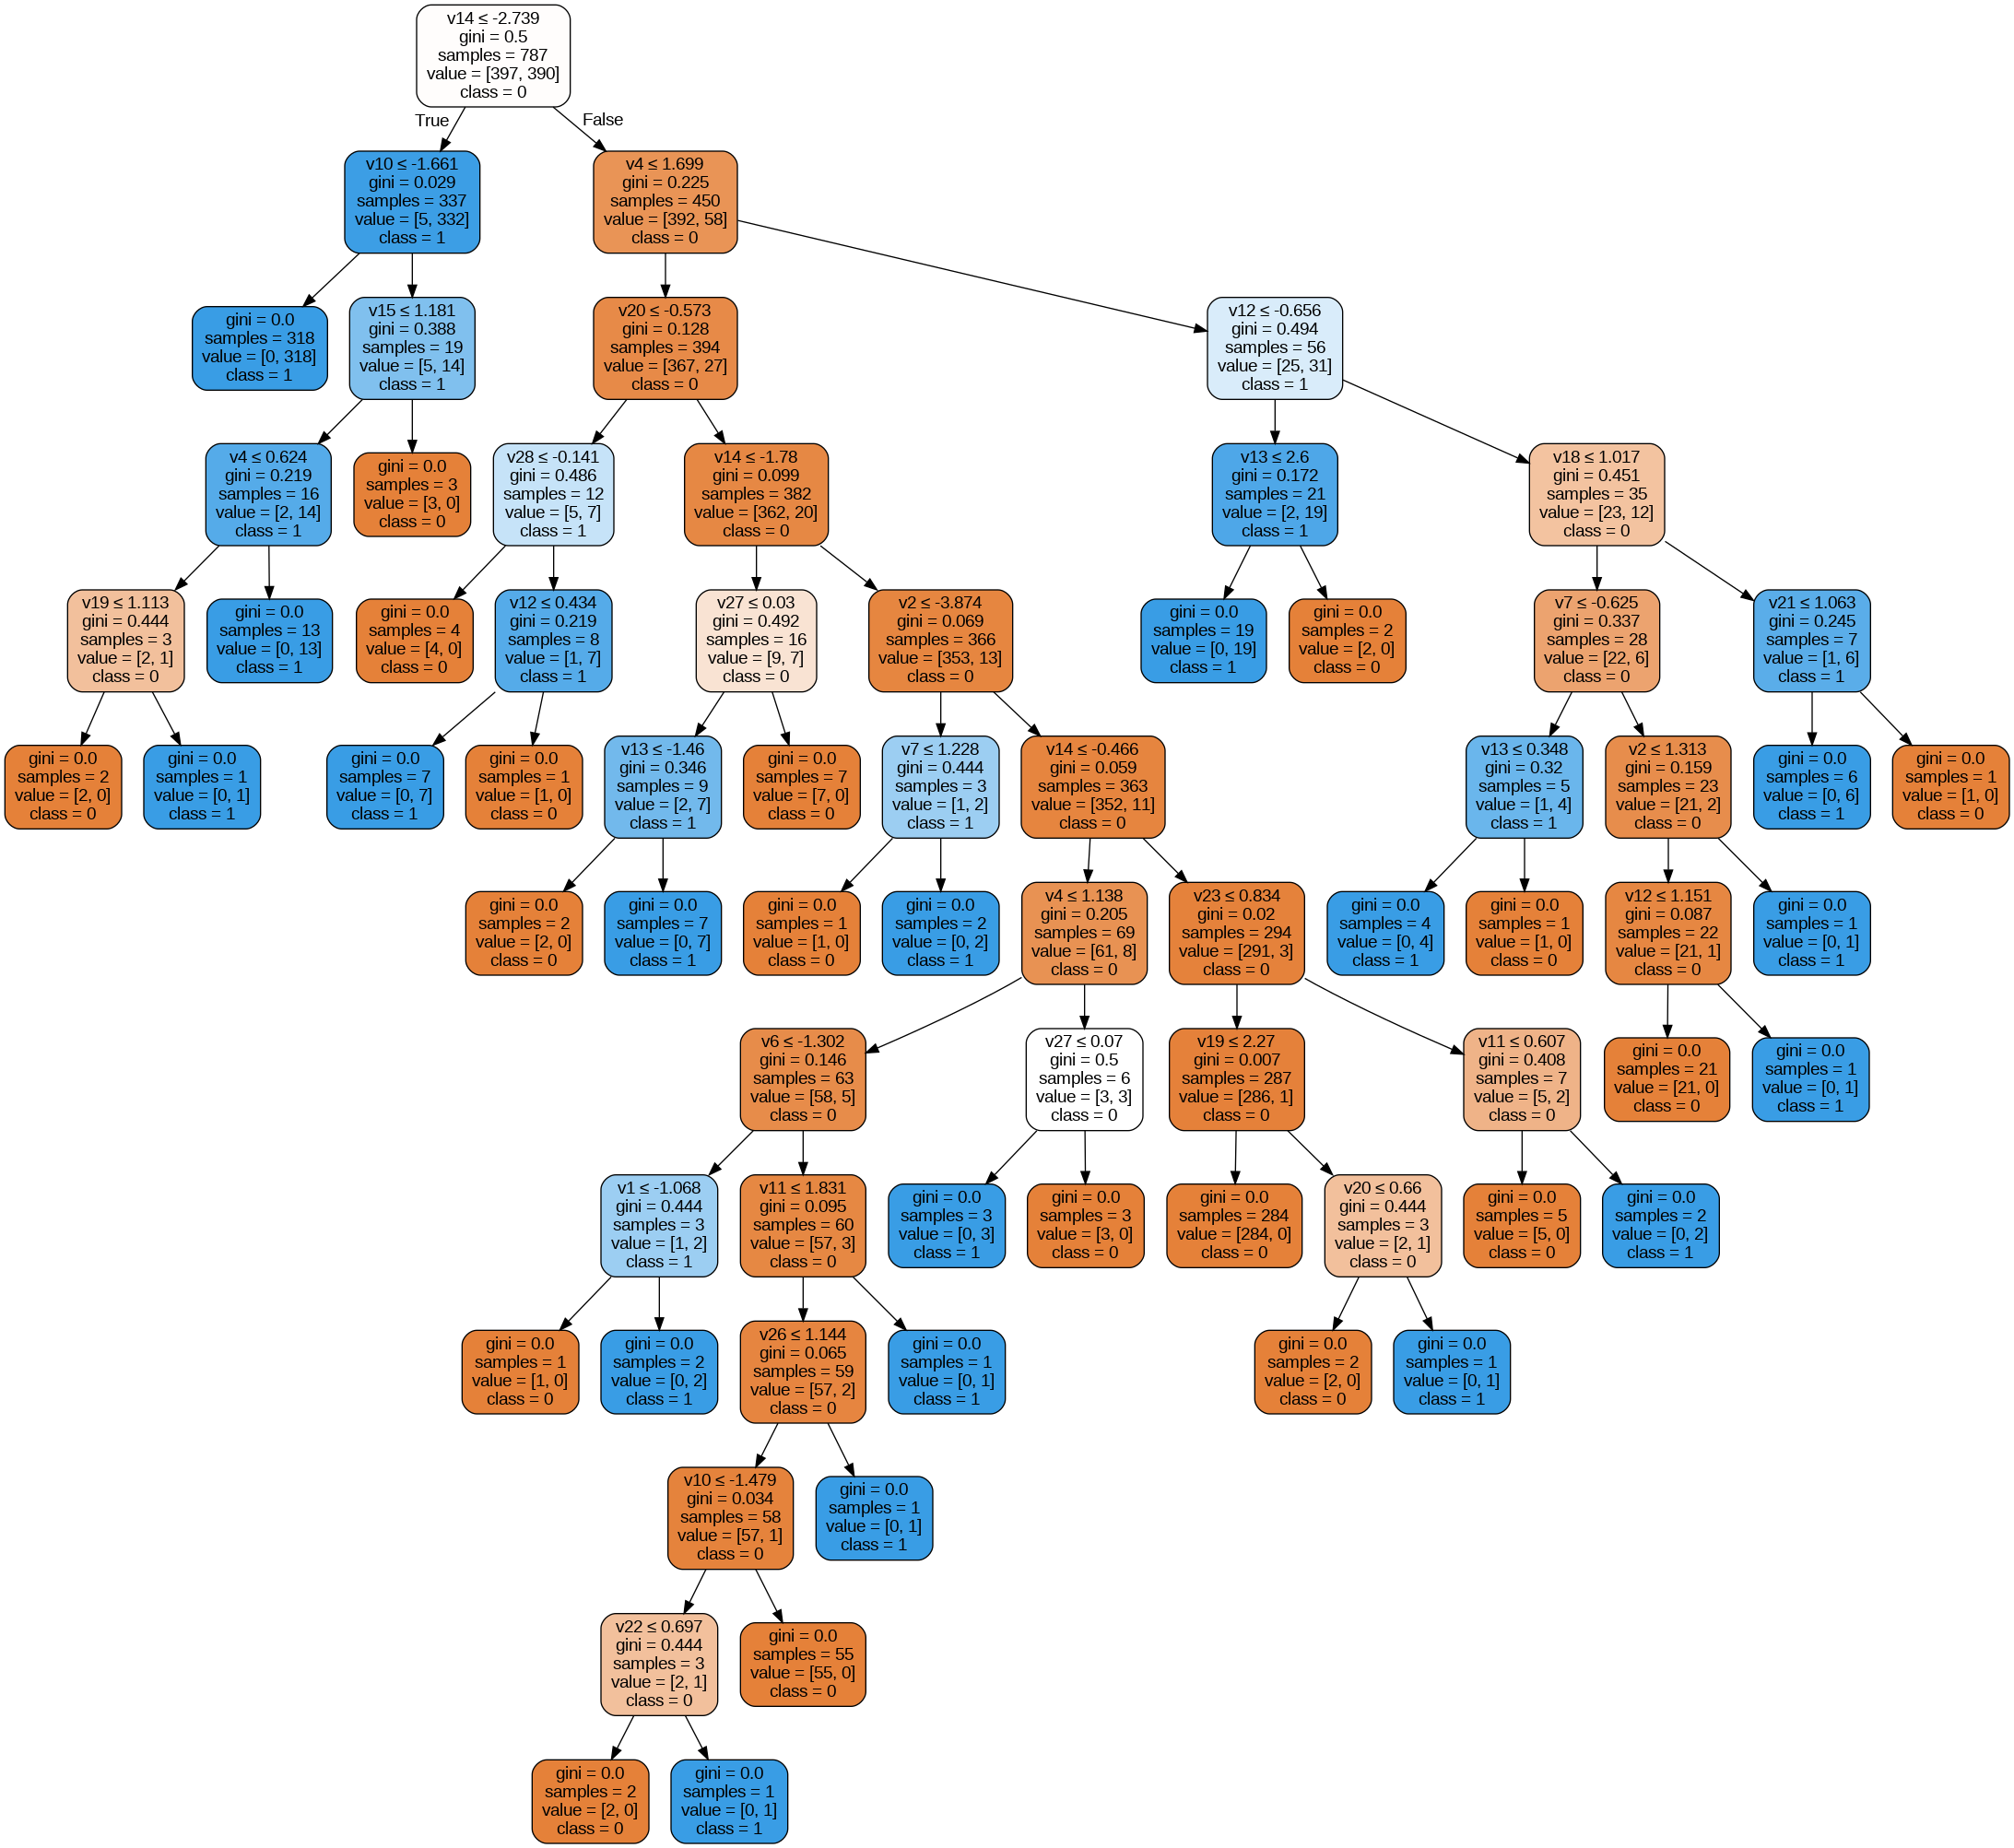

In [28]:
model = DecisionTreeClassifier()
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  filled=True, rounded=True, special_characters=True,
                feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(TMP_PATH+'dt.png')
Image(graph.create_png())

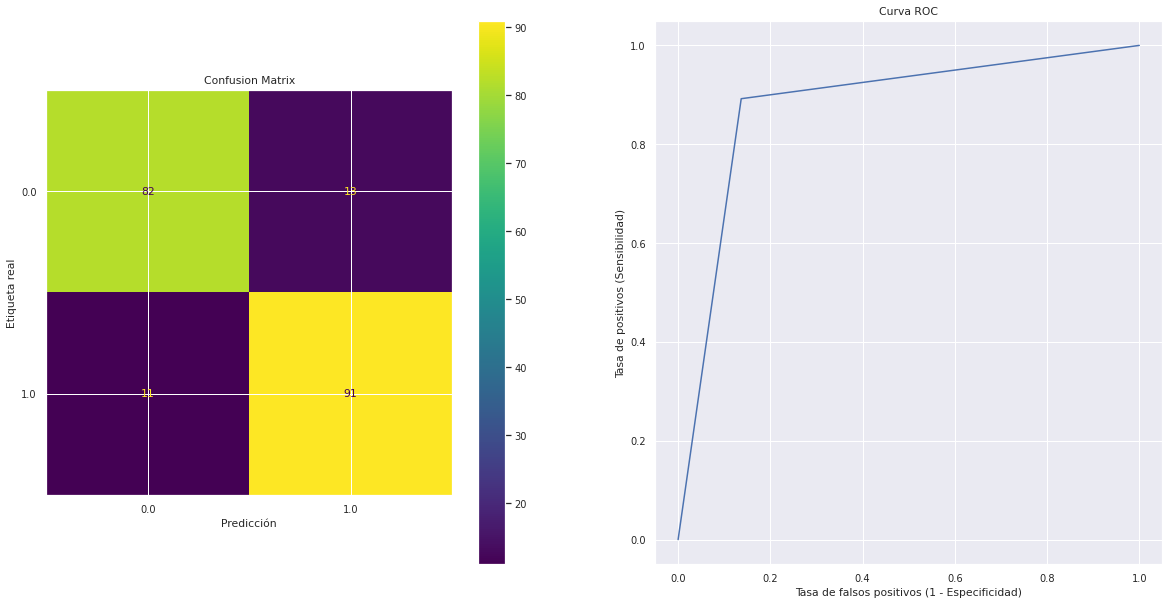

AUC: 0.8776573787409702
Accuracy: 0.8781725888324873
Precision: 0.875
Recall: 0.8921568627450981
f1-score:  0.883495145631068


In [29]:
model_name = "dt1"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,model_name+".pkl")


##### 4.2 Modelo 2, con otros parámetros

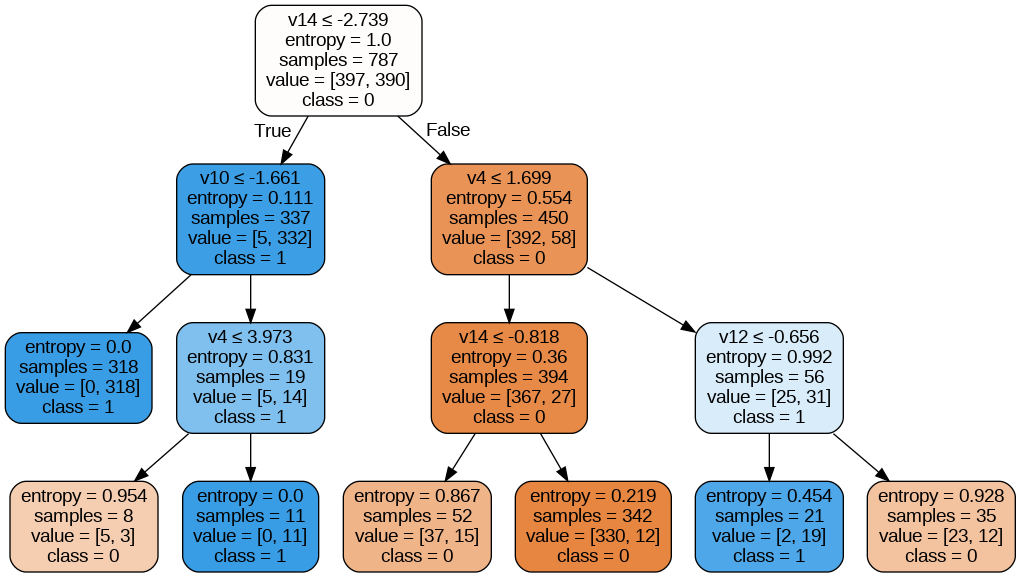

In [30]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=3)
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

dot_data = StringIO()
export_graphviz( model, out_file=dot_data,  filled=True, rounded=True, special_characters=True, 
                 feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(TMP_PATH+'dt_pruned.png')
Image(graph.create_png())

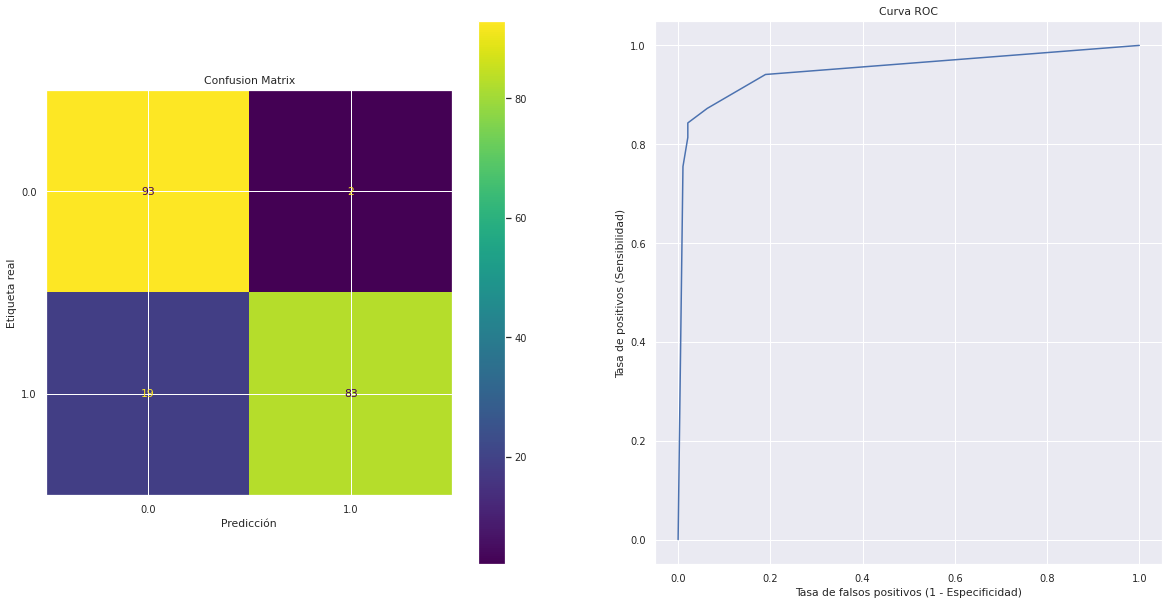

AUC: 0.9495872033023736
Accuracy: 0.8934010152284264
Precision: 0.9764705882352941
Recall: 0.8137254901960784
f1-score:  0.8877005347593584


In [31]:
model_name = "dt2"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,model_name+".pkl")

#### 4.2 Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

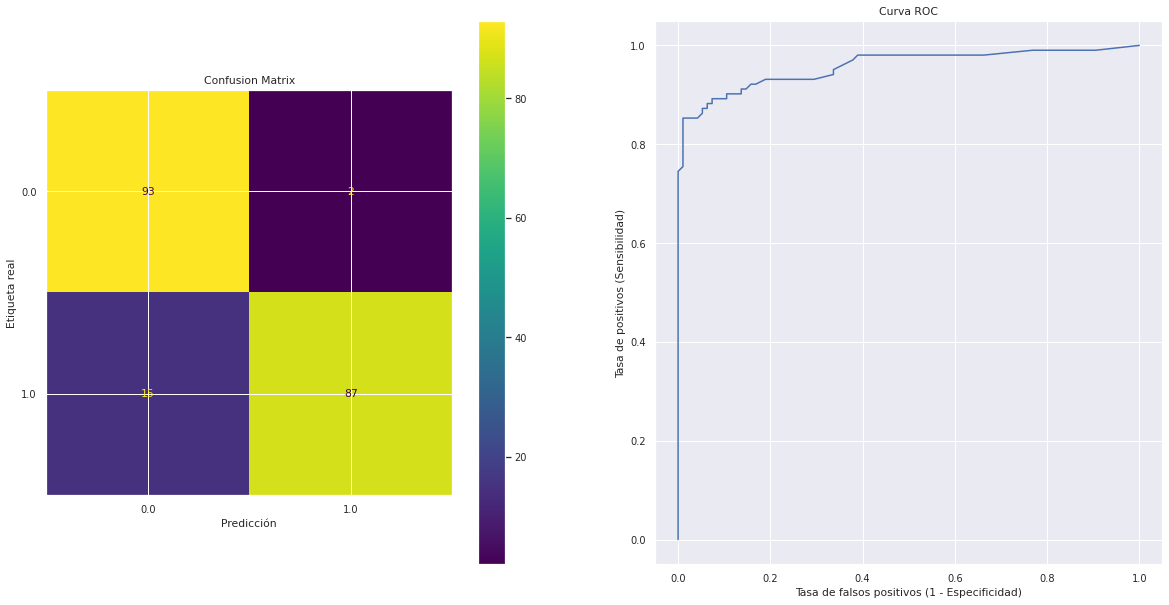

AUC: 0.9574303405572755
Accuracy: 0.9137055837563451
Precision: 0.9775280898876404
Recall: 0.8529411764705882
f1-score:  0.9109947643979056


In [33]:
model=RandomForestClassifier(n_estimators=100)
model = model.fit(X_train,y_train)
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_name = "rf1"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,model_name+".pkl")

#### 4.4 Regresión Logística

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


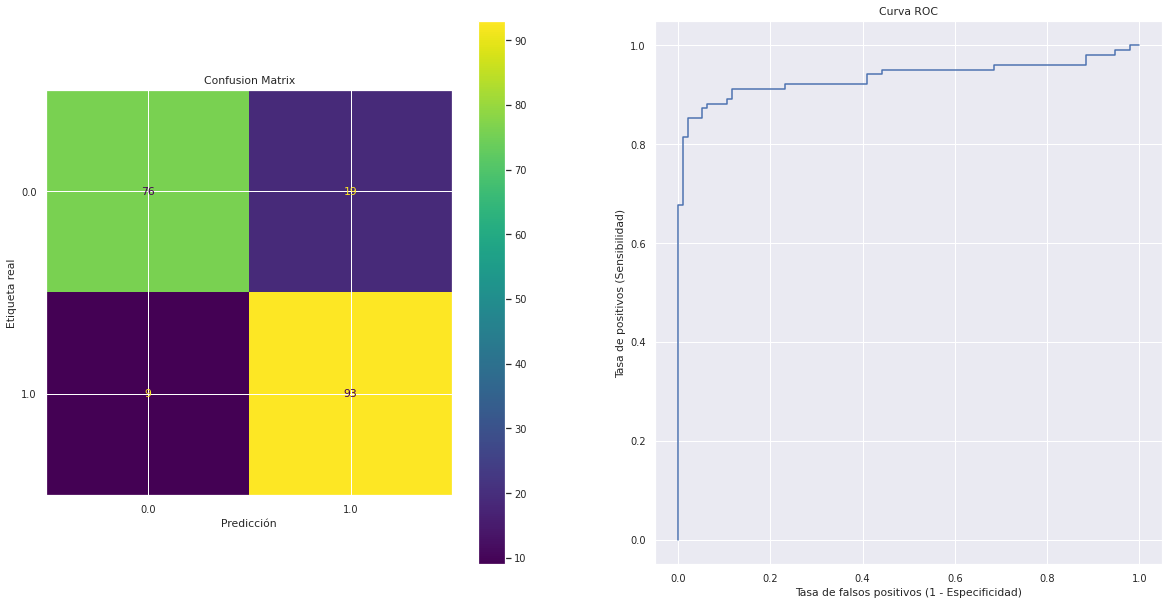

AUC: 0.9351909184726521
Accuracy: 0.8578680203045685
Precision: 0.8303571428571429
Recall: 0.9117647058823529
f1-score:  0.8691588785046729


In [34]:
model = LogisticRegression(C=1, solver="sag", max_iter=1000)
model = model.fit(X_train,y_train)
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_name="lr1"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,model_name+".pkl")

#### 3.5 SVM

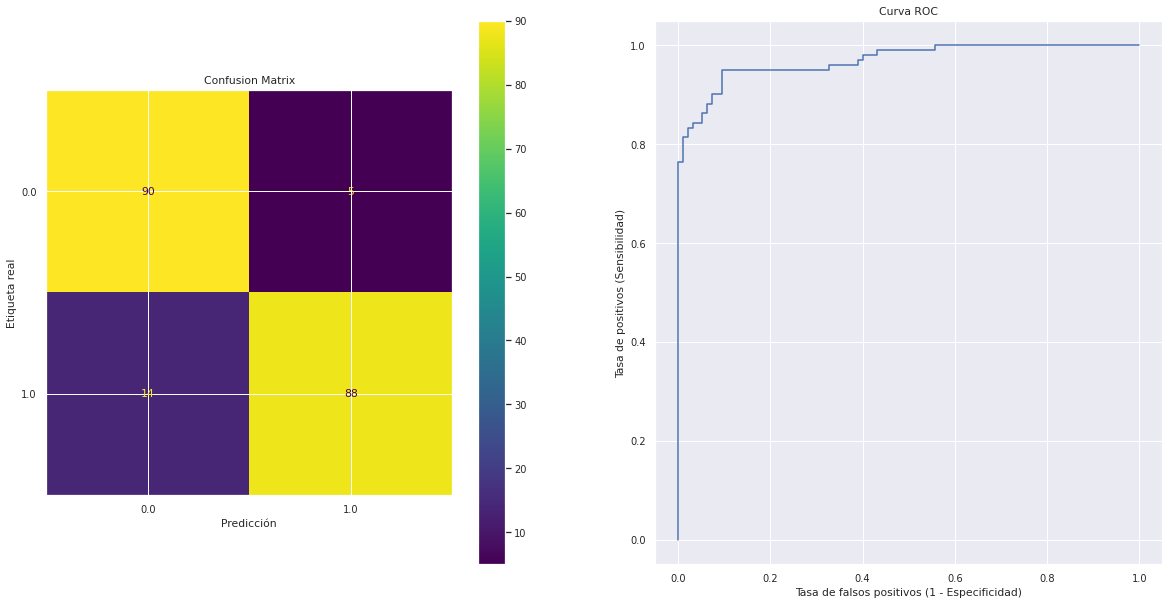

AUC: 0.9697626418988647
Accuracy: 0.9035532994923858
Precision: 0.946236559139785
Recall: 0.8627450980392157
f1-score:  0.9025641025641027


In [35]:
from sklearn import svm

model = svm.SVC(kernel='linear',probability=True) # Linear Kernel
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_name="svm1"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,model_name+".pkl")

#### 3.6 Multi Layer Perceptron

/opt/conda/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


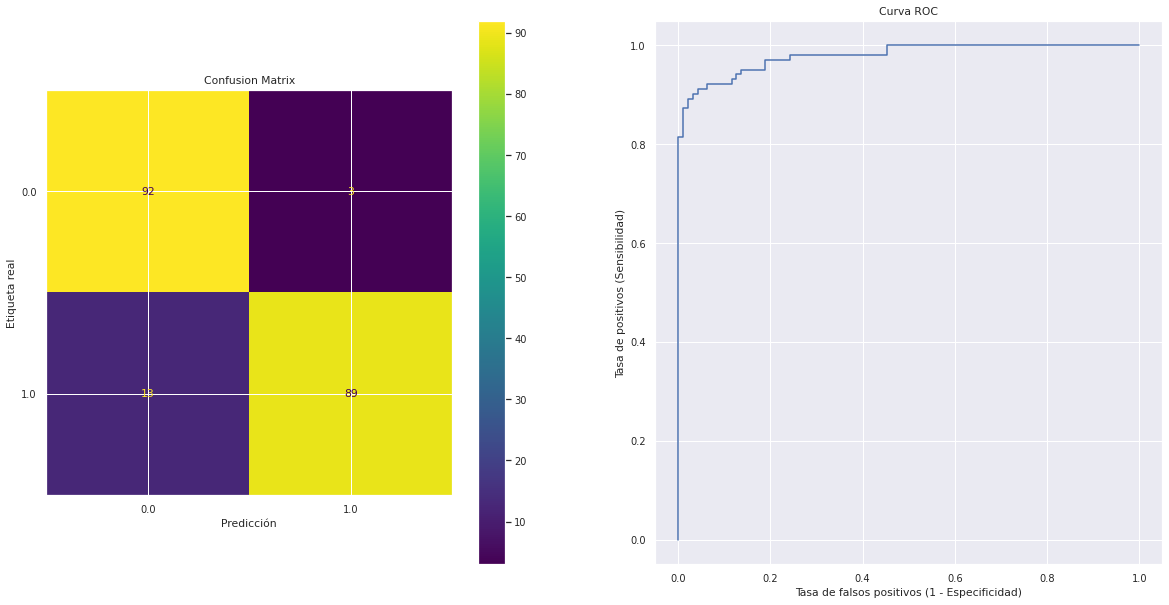

AUC: 0.9789473684210526
Accuracy: 0.934010152284264
Precision: 0.978494623655914
Recall: 0.8921568627450981
f1-score:  0.9333333333333333


In [47]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X, y)

model_name="mlp1"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,model_name+".pkl")

#### 3.7 XGBoost

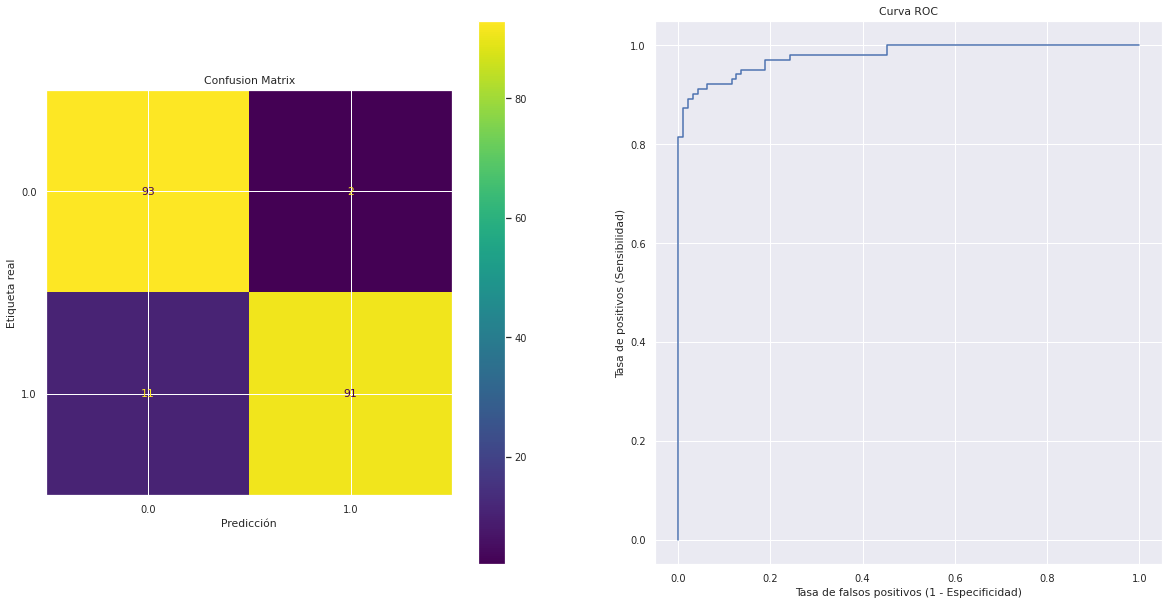

AUC: 0.9789473684210526
Accuracy: 0.934010152284264
Precision: 0.978494623655914
Recall: 0.8921568627450981
f1-score:  0.9333333333333333


In [45]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_name="xgboost"
model_metrics_list[model_name] = model_evaluation_report(model,y_test,y_pred,y_pred_prob)
save_model(model,model_name+".pkl")

## Comparación de resultados y conclusiones

In [48]:
pd.DataFrame.from_dict(model_metrics_list,orient='index')

,accuracy,precision,recall,auc,f1-score
dt1,0.878173,0.875000,0.892157,0.877657,0.883495
dt2,0.893401,0.976471,0.813725,0.949587,0.887701
rf1,0.913706,0.977528,0.852941,0.957430,0.910995
lr1,0.857868,0.830357,0.911765,0.935191,0.869159
svm1,0.903553,0.946237,0.862745,0.969763,0.902564
xgboost,0.934010,0.978495,0.892157,0.978947,0.933333
mlp1,0.934010,0.978495,0.892157,0.978947,0.933333


## Bibliografía y referencias

- TODO

# WIP, pruebas
<hr>